C:\Users\TSaber\AppData\Local\Temp\ipykernel_26464\1215082772.py:99: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 15)
C:\Users\TSaber\AppData\Local\Temp\ipykernel_26464\1215082772.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar1.set(xticklabels=[f'${r}^3$' for r in resolutions])


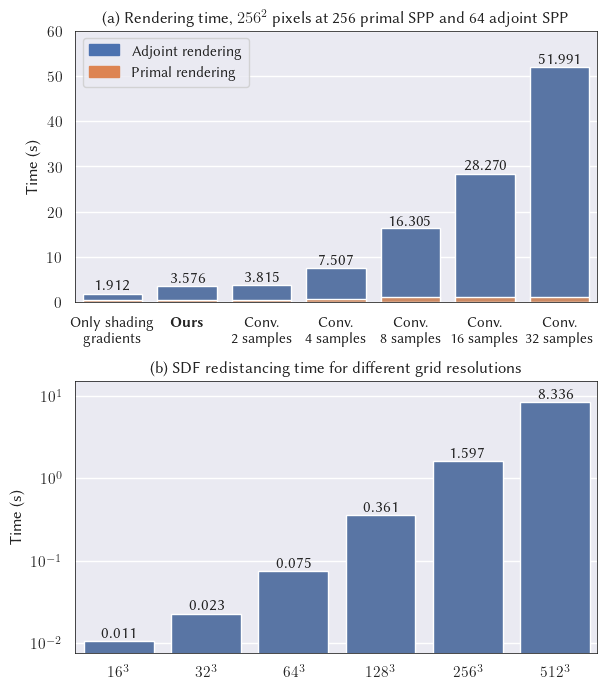

In [7]:
%reload_ext autoreload
%autoreload 2

import seaborn as sns

import sys
import os
sys.path.append(os.path.abspath('../'))
from common import *
import configs

import json
from benchmark import sum_stats
import matplotlib.patches as mpatches
import pandas as pd

fig_name = 'benchmark'
output_dir = join(FIGURE_DIR, fig_name)

sns.set()
sns.set_style('darkgrid', {'axes.edgecolor': 'black'})
matplotlib.rcParams['axes.linewidth'] = 0.5
sdfs = ['bunny_128', 'logo_256', 'shadowing_128']

used_configs = [configs.OnlyShadingGrad(), configs.Warp(), configs.ConvolutionWarp2(), configs.ConvolutionWarp4(),
                configs.ConvolutionWarp8(), configs.ConvolutionWarp16(), configs.ConvolutionWarp32()]
all_stats = {}
for sdf in sdfs:
    all_stats[sdf] = {}
    for config in used_configs:
        stats_fn = join(output_dir, f'{sdf.split("_")[0]}_{config.name}.json')
        with open(stats_fn, 'r') as f:
            all_stats[sdf][config.name] = json.load(f)

# Average over all sdfs
average_stats = {}
for config in used_configs:
    average_stats[config.name] = {}
    for sdf in sdfs:
        sum_stats(average_stats[config.name], all_stats[sdf][config.name], len(sdfs))

renaming = [
    'Only shading\n gradients',
    r'\textbf{Ours}', 'Conv. \n 2 samples',
    'Conv. \n 4 samples', 'Conv. \n 8 samples',
    'Conv. \n 16 samples', 'Conv. \n 32 samples'
]

for cfg, new_name in zip(used_configs, renaming):
    average_stats[new_name] = average_stats.pop(cfg.name)

df = pd.DataFrame.from_dict(average_stats).T
df = df / 1000
total_times = df.sum(axis=1).reset_index()
total_times.columns = ['Technique', 'Total']

y_offset = -0.1
fontsize = 12
base_size = 3
n_rows = 2
n_cols = 1
fig = plt.figure(1, figsize=(COLUMN_WIDTH, 1.2 * COLUMN_WIDTH), constrained_layout=False)
gs = fig.add_gridspec(n_rows, n_cols, wspace=0.025, hspace=0.29)

ax = fig.add_subplot(gs[0])
bar1 = sns.barplot(x="Technique", y="Total", data=total_times, color=sns.color_palette()[0], ax=ax)
df = df.reset_index()
df.columns = ['Technique', 'Primal rendering', 'Adjoint rendering']
bar2 = sns.barplot(x="Technique", y="Primal rendering", data=df, color=sns.color_palette()[1], ax=ax)

# Set up legend
top_bar = mpatches.Patch(color=sns.color_palette()[0], label='Adjoint rendering')
bottom_bar = mpatches.Patch(color=sns.color_palette()[1], label='Primal rendering')
plt.legend(handles=[top_bar, bottom_bar])
ax.set_ylabel('Time (s)', fontsize=fontsize)
ax.set_xlabel('')
ax.set_title("(a) Rendering time, $256^2$ pixels at 256 primal SPP and 64 adjoint SPP", fontsize=fontsize)
ax.bar_label(ax.containers[0], fmt='%.3f')
ax.set_ylim(0, 60)

# Second plot showing FSM timings
stats_fn = join(output_dir, f'fsm.json')
with open(stats_fn, 'r') as f:
    fsm_stats = json.load(f)

df = pd.DataFrame(fsm_stats)
avg_times = df.mean(axis=1).reset_index()
avg_times.columns = ['Resolution', 'Time']
ax = fig.add_subplot(gs[1])
bar1 = sns.barplot(x="Resolution", y="Time", data=avg_times, color=sns.color_palette()[0], ax=ax)
v_offset = 0.02
w_scale = 0.5
ax.set_yscale('log')

ax.bar_label(ax.containers[0], fmt='%.3f')
ax.set_ylabel('Time (s)', fontsize=fontsize)
ax.set_xlabel('')
ax.set_title("(b) SDF redistancing time for different grid resolutions",  fontsize=fontsize)
ax.set_ylim(0, 15)
ax.set_xlim(-0.5, 5.48)
resolutions = avg_times['Resolution']
bar1.set(xticklabels=[f'${r}^3$' for r in resolutions])
print()

# show the graph
plt.margins(0, 0)
# save_fig(fig_name)